In [1]:
!pip install -qq einops

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
EPOCHS = 50
NUM_CLASSES = 1  

**Sample image with GT mask**

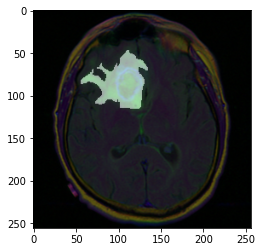

In [5]:
mask = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif")
mask = np.array(mask)[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)

image = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif")
image = np.array(image)

image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

plt.imshow(image)
plt.show()

**Collect images and corresponding masks**

In [5]:
all_paths = glob("../input/lgg-mri-segmentation/kaggle_3m/*/*.tif")
images_paths = sorted([path for path in all_paths if "mask" not in path])
masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
masks_paths = [path + "_mask.tif" for path in masks_paths]
del all_paths; gc.collect()

61

In [6]:
data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

x_train, x_valid = train_test_split(data, test_size=500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=0.5, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 3429, validation size: 250, test size: 250


In [8]:
x_train.sample(5)

,image,mask
578,../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38.tif,../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38_mask.tif
1055,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11.tif,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11_mask.tif
564,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40.tif,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif
2298,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14.tif,../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif
3243,../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44.tif,../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif


**Dataset, augmentations, dataloader**

In [7]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [8]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)
        
        mask = Image.open(row["mask"])
        mask = np.array(mask)
        
        mask = np.where(mask > 127, 255, 0)
        
        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)
        
        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]
        
        return image, mask / 255.
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [10]:
train_ds = SegDataset(x_train, train_transforms)
valid_ds = SegDataset(x_valid, valid_transforms)
test_ds = SegDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

**Model architecture**

<img src=attachment:249ad647-667a-41ce-b801-e0ef45b17aaa.png width=1200>
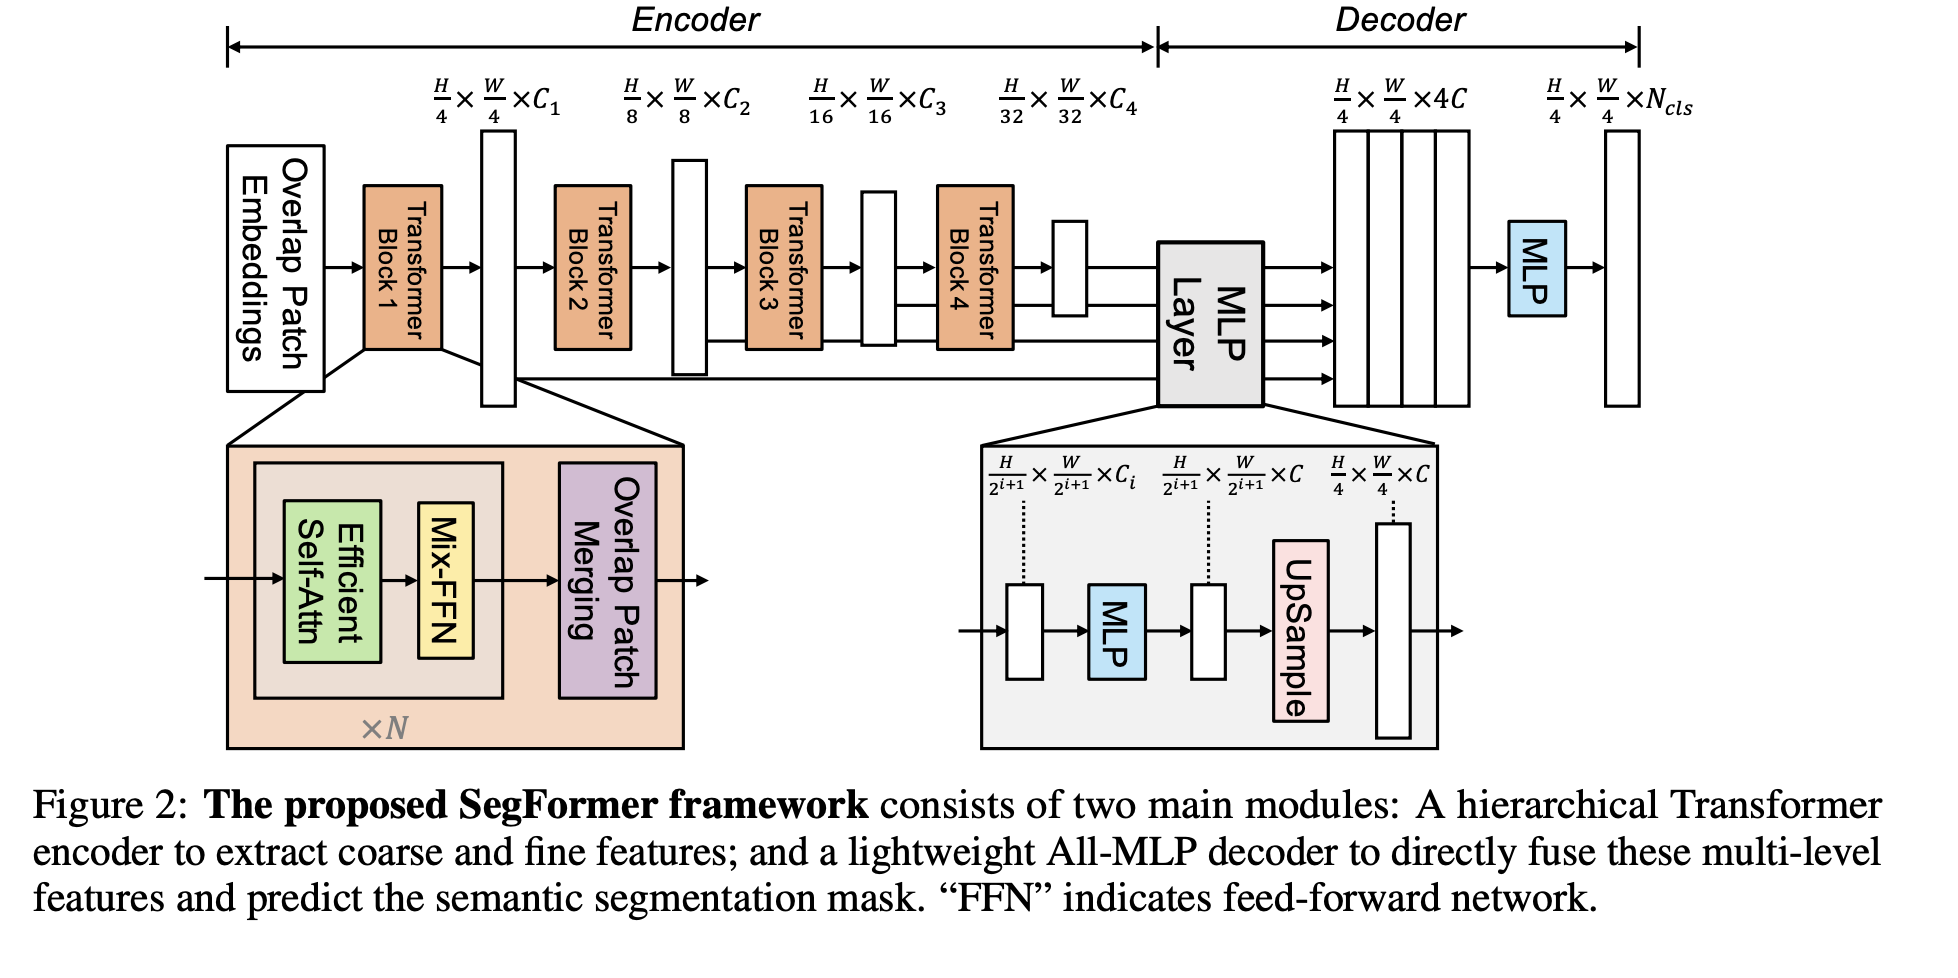

In [11]:
# https://github.com/FrancescoSaverioZuppichini/SegFormer

class LayerNorm2d(nn.LayerNorm):
    """ swap channel dim, apply layer norm and swap back: see https://github.com/pytorch/pytorch/issues/71465 """
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x
    
class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super(OverlapPatchMerging, self).__init__(
                                        nn.Conv2d(
                                            in_channels,
                                            out_channels,
                                            kernel_size=patch_size,
                                            stride=overlap_size,
                                            padding=patch_size // 2,
                                            bias=False
                                        ),
                                        LayerNorm2d(out_channels)
                                    )

In [12]:
# positional encoding eliminated as for original paper: https://arxiv.org/pdf/2105.15203.pdf

class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V 
        x = rearrange(x, "b c h w -> b (h w) c")  # Q
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out
    
# transformer FFN block, here fully convolutional

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # linear layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),
            # linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [13]:
class ResidualAdd(nn.Module):
    """ A layer that helps to add&norm MHA and FFN outputs """
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    """ Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly """
    def __init__(
                self,
                channels: int,
                reduction_ratio: int = 1,
                num_heads: int = 8,
                mlp_expansion: int = 4,
                drop_path_prob: float = .0
            ):
        super(SegFormerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")  # https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html
                )
            ),
        )

In [14]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [15]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk
        
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )
        
    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [16]:
# decoder 
class SegFormerDecoderBlock(nn.Sequential):
    """ upsample """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )
        
class SegFormerDecoder(nn.Module):
    """ takes a list of features and returns a list of new features with the same spatial size and channels """
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )
    
    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [17]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)  # paper
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)  # concatenate all features obtained before (they have same spatial dims and channels)
        x = self.fuse(x)  # conv and normalize
        x = self.predict(x)  # get final feature map(s)
        return x

In [18]:
# final model: encoder -> decoder -> head

class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super(SegFormer, self).__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])  # in the reverse order
        segmentation = self.head(features)
        return segmentation

In [19]:
# check model
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

segmentation = segformer(torch.randn((1, 3, 224, 224)))
segmentation.shape # torch.Size([1, 2, 56, 56])

torch.Size([1, 1, 56, 56])

**Train / Validation / Visualization functions**

In [59]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5, pos_only=False):
    model.train()
    images, masks = data
    
    optimizer.zero_grad()
    out = model(images)  # [B, 1, 56, 56]
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]
    
    loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones

    loss.backward()
    optimizer.step()
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    if pos_only and torch.all(torch.any(masks.view(BATCH_SIZE, -1), dim=1)):
        pos_mask = (masks != 0)
    else:
        pos_mask = (masks == masks)
    mask_accuracy = (out[pos_mask] == masks[pos_mask]).float().mean()  # binary accuracy, ignoring negative class
    
    return loss.item(), mask_accuracy.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5, pos_only=False):
    model.eval()
    images, masks = data
    out = model(images)
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    
    loss = criterion(out, masks)
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    if pos_only and torch.all(torch.any(masks.view(BATCH_SIZE, -1), dim=1)):
        pos_mask = (masks != 0)
    else:
        pos_mask = (masks == masks)
    mask_accuracy = (out[pos_mask] == masks[pos_mask]).float().mean()
    
    return loss.item(), mask_accuracy.item()

@torch.no_grad()
def test_plot(model, threshold=0.5):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
    
    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask = np.repeat(mask, 3, axis=-1)
    
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    out = model(inputs)
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= threshold, 1, 0)  # as out consists only of one channel with sigmoid values of estimated probability of positive label [0,1], argmax(1) otherwise
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

**Define model, loss_fn, optimizer, scheduler, early stopping**

In [21]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

**Losses**

In [29]:
# great kaggle kernel with semantic segmentation losses: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
import torch.nn.functional as F

ALPHA = 0.4
BETA = 0.6
GAMMA = 2

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1., size_average=True):
        super(DiceBCELoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + self.weight * dice_loss
        
        return Dice_BCE
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [60]:
model = SegFormer(
                in_channels=3,
                widths=[64, 128, 256, 512],
                depths=[3, 4, 6, 3],
                all_num_heads=[1, 2, 4, 8],
                patch_sizes=[7, 3, 3, 3],
                overlap_sizes=[4, 2, 2, 2],
                reduction_ratios=[8, 4, 2, 1],
                mlp_expansions=[4, 4, 4, 4],
                decoder_channels=256,
                scale_factors=[8, 4, 2, 1],
                num_classes=NUM_CLASSES,
                                        ).to(device)

criterion = nn.BCEWithLogitsLoss()  # add pos_weight? tensor of size [2,]
# criterion = DiceBCELoss()
# criterion = IoULoss()
# criterion = FocalTverskyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=8)

**Training Loop**

In [24]:
print_feq = 100

epoch: 1 	step: 1 / 430 	train loss: 0.7059 	train accuracy: 0.3369 	time: 25.0275 s
epoch: 1 	step: 101 / 430 	train loss: 0.6303 	train accuracy: 0.8819 	time: 21.6036 s
epoch: 1 	step: 201 / 430 	train loss: 0.5660 	train accuracy: 0.9622 	time: 21.5645 s
epoch: 1 	step: 301 / 430 	train loss: 0.4671 	train accuracy: 0.9892 	time: 21.4198 s
epoch: 1 	step: 401 / 430 	train loss: 0.3473 	train accuracy: 0.9822 	time: 21.5047 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 1 / 51 	train loss: 0.5409 	valid loss: 0.8513 	train accuracy 0.9127 	valid accuracy 0.1004


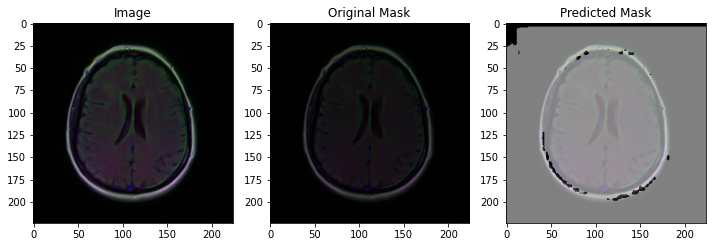

epoch: 2 	step: 1 / 430 	train loss: 0.3598 	train accuracy: 0.9787 	time: 21.5478 s
epoch: 2 	step: 101 / 430 	train loss: 0.2710 	train accuracy: 0.9824 	time: 21.6603 s
epoch: 2 	step: 201 / 430 	train loss: 0.1675 	train accuracy: 0.9867 	time: 21.4258 s
epoch: 2 	step: 301 / 430 	train loss: 0.1443 	train accuracy: 0.9922 	time: 21.4596 s
epoch: 2 	step: 401 / 430 	train loss: 0.1195 	train accuracy: 0.9928 	time: 21.7483 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 2 / 51 	train loss: 0.2005 	valid loss: 0.1340 	train accuracy 0.9907 	valid accuracy 0.9922


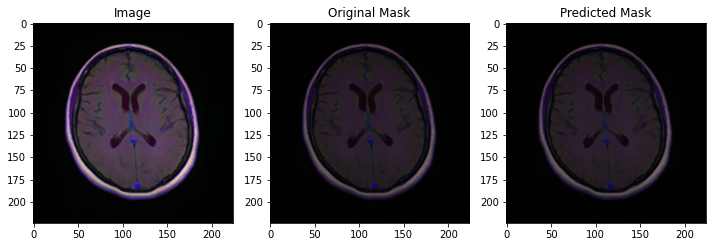

Model saved to: model.pth
epoch: 3 	step: 1 / 430 	train loss: 0.1119 	train accuracy: 0.9899 	time: 21.6196 s
epoch: 3 	step: 101 / 430 	train loss: 0.1398 	train accuracy: 0.9779 	time: 21.3702 s
epoch: 3 	step: 201 / 430 	train loss: 0.0674 	train accuracy: 0.9947 	time: 21.6477 s
epoch: 3 	step: 301 / 430 	train loss: 0.0550 	train accuracy: 0.9954 	time: 21.5846 s
epoch: 3 	step: 401 / 430 	train loss: 0.0404 	train accuracy: 0.9979 	time: 21.4413 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 3 / 51 	train loss: 0.0753 	valid loss: 0.0476 	train accuracy 0.9917 	valid accuracy 0.9924


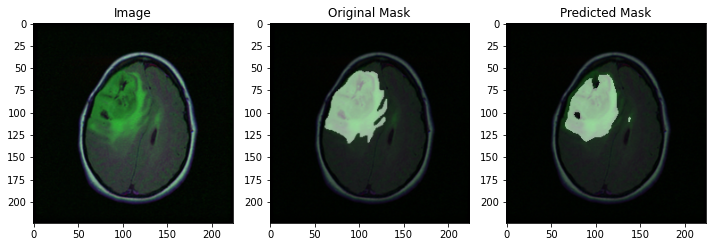

Model saved to: model.pth
epoch: 4 	step: 1 / 430 	train loss: 0.0368 	train accuracy: 0.9999 	time: 22.4074 s
epoch: 4 	step: 101 / 430 	train loss: 0.0487 	train accuracy: 0.9934 	time: 22.4761 s
epoch: 4 	step: 201 / 430 	train loss: 0.0520 	train accuracy: 0.9910 	time: 23.0071 s
epoch: 4 	step: 301 / 430 	train loss: 0.0575 	train accuracy: 0.9885 	time: 22.3122 s
epoch: 4 	step: 401 / 430 	train loss: 0.0249 	train accuracy: 0.9973 	time: 22.3773 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 4 / 51 	train loss: 0.0442 	valid loss: 0.0322 	train accuracy 0.9925 	valid accuracy 0.9929


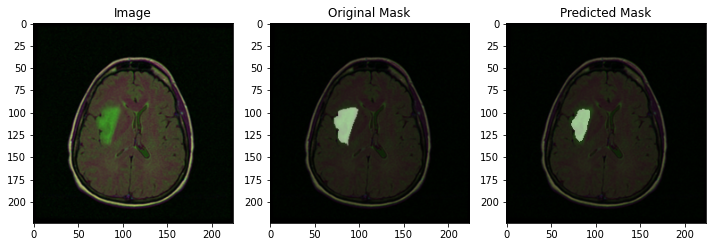

Model saved to: model.pth
epoch: 5 	step: 1 / 430 	train loss: 0.0657 	train accuracy: 0.9827 	time: 21.5973 s
epoch: 5 	step: 101 / 430 	train loss: 0.0266 	train accuracy: 0.9958 	time: 21.5251 s
epoch: 5 	step: 201 / 430 	train loss: 0.0522 	train accuracy: 0.9846 	time: 21.5199 s
epoch: 5 	step: 301 / 430 	train loss: 0.0288 	train accuracy: 0.9929 	time: 21.6303 s
epoch: 5 	step: 401 / 430 	train loss: 0.0424 	train accuracy: 0.9867 	time: 21.5663 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 5 / 51 	train loss: 0.0347 	valid loss: 0.0253 	train accuracy 0.9927 	valid accuracy 0.9930


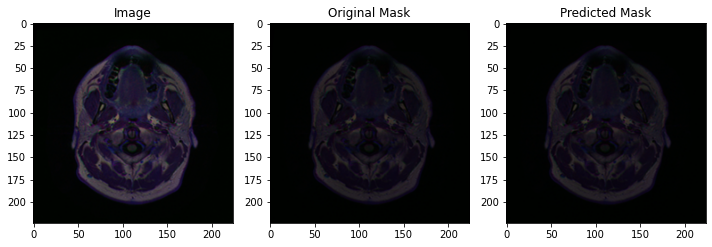

Model saved to: model.pth
epoch: 6 	step: 1 / 430 	train loss: 0.0208 	train accuracy: 0.9967 	time: 21.4383 s
epoch: 6 	step: 101 / 430 	train loss: 0.0263 	train accuracy: 0.9943 	time: 21.3562 s
epoch: 6 	step: 201 / 430 	train loss: 0.0234 	train accuracy: 0.9946 	time: 21.6619 s
epoch: 6 	step: 301 / 430 	train loss: 0.0178 	train accuracy: 0.9958 	time: 21.5548 s
epoch: 6 	step: 401 / 430 	train loss: 0.0263 	train accuracy: 0.9941 	time: 21.4357 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 6 / 51 	train loss: 0.0296 	valid loss: 0.0282 	train accuracy 0.9929 	valid accuracy 0.9933


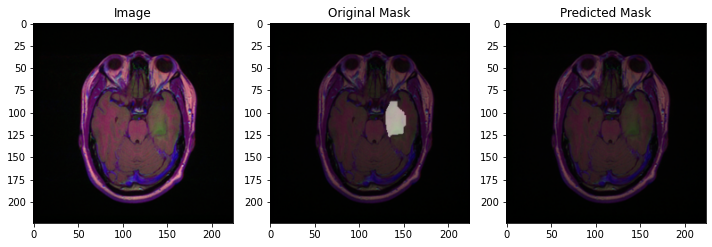

INFO: Early stopping counter 1 of 8
epoch: 7 	step: 1 / 430 	train loss: 0.0335 	train accuracy: 0.9936 	time: 21.4918 s
epoch: 7 	step: 101 / 430 	train loss: 0.0468 	train accuracy: 0.9890 	time: 21.6295 s
epoch: 7 	step: 201 / 430 	train loss: 0.0099 	train accuracy: 0.9992 	time: 21.4473 s
epoch: 7 	step: 301 / 430 	train loss: 0.0432 	train accuracy: 0.9852 	time: 21.4991 s
epoch: 7 	step: 401 / 430 	train loss: 0.0202 	train accuracy: 0.9938 	time: 21.4835 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 7 / 51 	train loss: 0.0277 	valid loss: 0.0280 	train accuracy 0.9932 	valid accuracy 0.9926


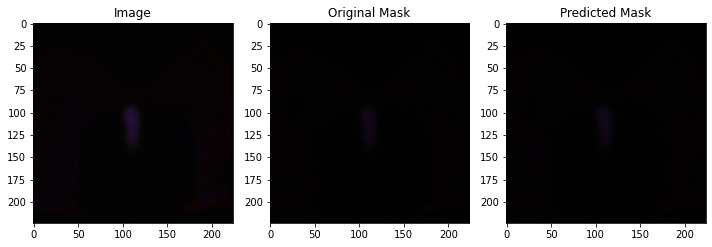

INFO: Early stopping counter 2 of 8
epoch: 8 	step: 1 / 430 	train loss: 0.0146 	train accuracy: 0.9969 	time: 21.4852 s
epoch: 8 	step: 101 / 430 	train loss: 0.0089 	train accuracy: 0.9995 	time: 21.6854 s
epoch: 8 	step: 201 / 430 	train loss: 0.0197 	train accuracy: 0.9939 	time: 21.6203 s
epoch: 8 	step: 301 / 430 	train loss: 0.0086 	train accuracy: 0.9989 	time: 21.5757 s
epoch: 8 	step: 401 / 430 	train loss: 0.0113 	train accuracy: 0.9973 	time: 21.5364 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 8 / 51 	train loss: 0.0255 	valid loss: 0.0212 	train accuracy 0.9934 	valid accuracy 0.9941


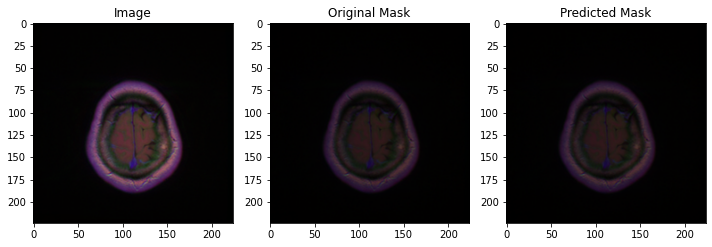

Model saved to: model.pth
epoch: 9 	step: 1 / 430 	train loss: 0.0161 	train accuracy: 0.9973 	time: 21.6538 s
epoch: 9 	step: 101 / 430 	train loss: 0.0361 	train accuracy: 0.9918 	time: 21.6362 s
epoch: 9 	step: 201 / 430 	train loss: 0.0120 	train accuracy: 0.9964 	time: 21.4563 s
epoch: 9 	step: 301 / 430 	train loss: 0.0194 	train accuracy: 0.9937 	time: 21.5249 s
epoch: 9 	step: 401 / 430 	train loss: 0.0076 	train accuracy: 0.9988 	time: 21.6217 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 9 / 51 	train loss: 0.0245 	valid loss: 0.0199 	train accuracy 0.9935 	valid accuracy 0.9943


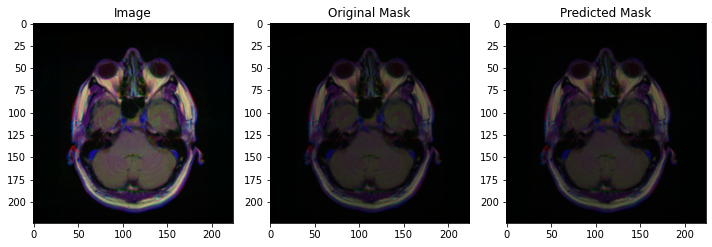

Model saved to: model.pth
epoch: 10 	step: 1 / 430 	train loss: 0.0119 	train accuracy: 0.9975 	time: 21.6500 s
epoch: 10 	step: 101 / 430 	train loss: 0.0111 	train accuracy: 0.9978 	time: 21.5966 s
epoch: 10 	step: 201 / 430 	train loss: 0.0185 	train accuracy: 0.9949 	time: 21.6378 s
epoch: 10 	step: 301 / 430 	train loss: 0.0282 	train accuracy: 0.9889 	time: 21.4503 s
epoch: 10 	step: 401 / 430 	train loss: 0.0098 	train accuracy: 0.9979 	time: 21.8083 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 10 / 51 	train loss: 0.0232 	valid loss: 0.0195 	train accuracy 0.9937 	valid accuracy 0.9944


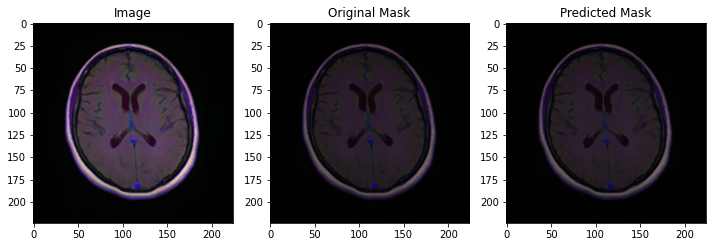

Model saved to: model.pth
epoch: 11 	step: 1 / 430 	train loss: 0.0063 	train accuracy: 0.9993 	time: 21.5614 s
epoch: 11 	step: 101 / 430 	train loss: 0.0152 	train accuracy: 0.9949 	time: 24.7214 s
epoch: 11 	step: 201 / 430 	train loss: 0.0135 	train accuracy: 0.9959 	time: 21.5125 s
epoch: 11 	step: 301 / 430 	train loss: 0.0249 	train accuracy: 0.9903 	time: 21.4676 s
epoch: 11 	step: 401 / 430 	train loss: 0.0223 	train accuracy: 0.9955 	time: 21.7525 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 11 / 51 	train loss: 0.0222 	valid loss: 0.0177 	train accuracy 0.9938 	valid accuracy 0.9946


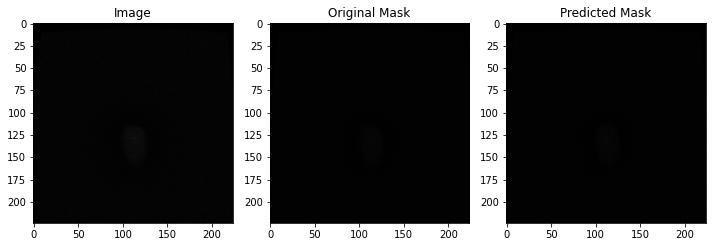

Model saved to: model.pth
epoch: 12 	step: 1 / 430 	train loss: 0.0180 	train accuracy: 0.9936 	time: 21.6322 s
epoch: 12 	step: 101 / 430 	train loss: 0.0140 	train accuracy: 0.9961 	time: 21.5932 s
epoch: 12 	step: 201 / 430 	train loss: 0.0227 	train accuracy: 0.9919 	time: 21.5400 s
epoch: 12 	step: 301 / 430 	train loss: 0.0060 	train accuracy: 0.9990 	time: 21.5902 s
epoch: 12 	step: 401 / 430 	train loss: 0.0310 	train accuracy: 0.9920 	time: 22.4155 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 12 / 51 	train loss: 0.0217 	valid loss: 0.0222 	train accuracy 0.9937 	valid accuracy 0.9927


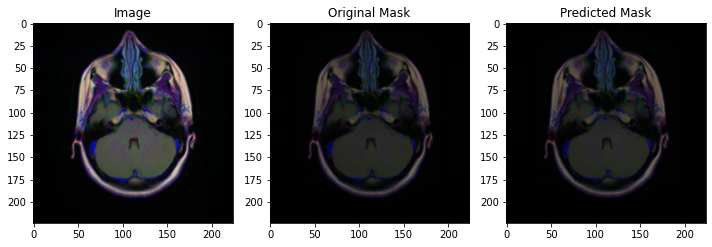

INFO: Early stopping counter 1 of 8
epoch: 13 	step: 1 / 430 	train loss: 0.0744 	train accuracy: 0.9780 	time: 21.6363 s
epoch: 13 	step: 101 / 430 	train loss: 0.0054 	train accuracy: 0.9994 	time: 21.4365 s
epoch: 13 	step: 201 / 430 	train loss: 0.0057 	train accuracy: 0.9995 	time: 21.4841 s
epoch: 13 	step: 301 / 430 	train loss: 0.0058 	train accuracy: 0.9990 	time: 21.5472 s
epoch: 13 	step: 401 / 430 	train loss: 0.0160 	train accuracy: 0.9966 	time: 21.4488 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 13 / 51 	train loss: 0.0192 	valid loss: 0.0167 	train accuracy 0.9941 	valid accuracy 0.9946


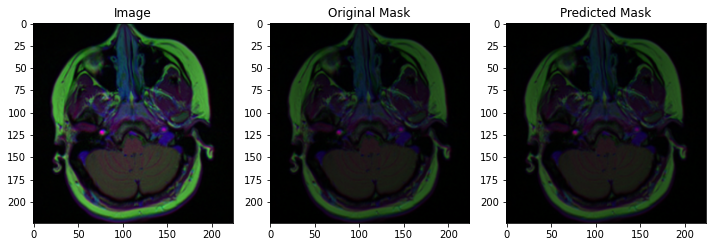

Model saved to: model.pth
epoch: 14 	step: 1 / 430 	train loss: 0.0139 	train accuracy: 0.9959 	time: 21.5344 s
epoch: 14 	step: 101 / 430 	train loss: 0.0138 	train accuracy: 0.9936 	time: 21.4332 s
epoch: 14 	step: 201 / 430 	train loss: 0.0168 	train accuracy: 0.9946 	time: 21.5911 s
epoch: 14 	step: 301 / 430 	train loss: 0.0325 	train accuracy: 0.9915 	time: 22.1070 s
epoch: 14 	step: 401 / 430 	train loss: 0.0166 	train accuracy: 0.9935 	time: 21.4850 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 14 / 51 	train loss: 0.0186 	valid loss: 0.0154 	train accuracy 0.9942 	valid accuracy 0.9949


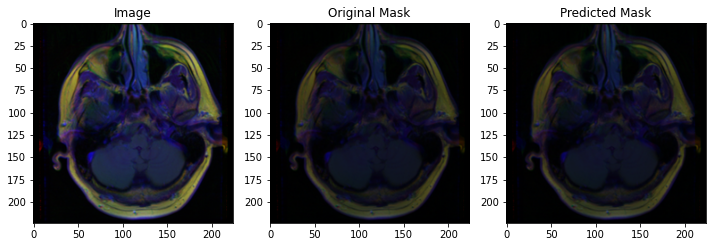

Model saved to: model.pth
epoch: 15 	step: 1 / 430 	train loss: 0.0518 	train accuracy: 0.9795 	time: 21.7127 s
epoch: 15 	step: 101 / 430 	train loss: 0.0084 	train accuracy: 0.9970 	time: 21.4670 s
epoch: 15 	step: 201 / 430 	train loss: 0.0087 	train accuracy: 0.9973 	time: 21.5580 s
epoch: 15 	step: 301 / 430 	train loss: 0.0195 	train accuracy: 0.9939 	time: 21.4526 s
epoch: 15 	step: 401 / 430 	train loss: 0.0500 	train accuracy: 0.9882 	time: 21.5902 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 15 / 51 	train loss: 0.0168 	valid loss: 0.0127 	train accuracy 0.9946 	valid accuracy 0.9954


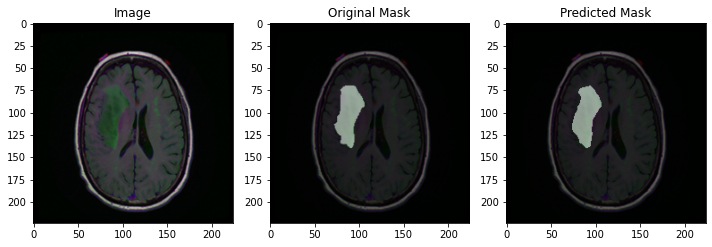

Model saved to: model.pth
epoch: 16 	step: 1 / 430 	train loss: 0.0061 	train accuracy: 0.9981 	time: 21.4592 s


KeyboardInterrupt: 

In [61]:
import time

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_feq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step+1, '/', len(train_dl) + 1,
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS+1,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
            '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
            '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    
    test_plot(model)
    
    stopper(np.mean(valid_loss))
    scheduler.step(np.mean(valid_loss))

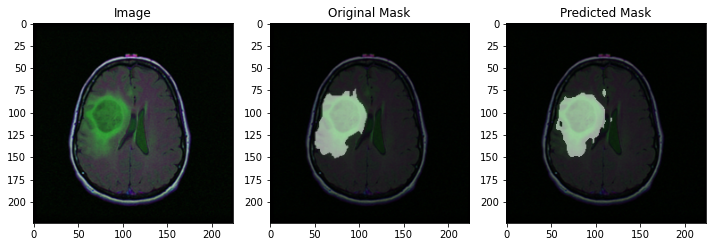

In [82]:
test_plot(model)

## [Baseline Results](https://www.kaggle.com/code/pankratozzi/segformer-with-pytorch?scriptVersionId=110767297)